In [ ]:
import os
import pandas as pd
import ast
from dotenv import load_dotenv
from neo4j import GraphDatabase
from IPython.display import Markdown, display

# Importing Langchain
# from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_google_genai import GoogleGenerativeAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_community.graphs import Neo4jGraph
from typing import List, Tuple, Dict, Any
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import ast
import logging
from tenacity import retry, stop_after_attempt, wait_exponential
import re
from langchain.chains import GraphCypherQAChain

from langchain_google_genai import ChatGoogleGenerativeAI

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")

ImportError: cannot import name 'RunnableSequence' from 'langchain.chains' (/Users/cristianleo/Documents/Documents - Cristian’s Laptop/GitHub/rag-knowledge-graph/venv/lib/python3.12/site-packages/langchain/chains/__init__.py)

In [2]:
movies = pd.read_csv('data/imdb_top_1000.csv').head(10)

movies.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [3]:
# Set up Neo4j connection
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()
        print("Connection closed")

    def reset_database(self):
        with self.driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")
        print("Database resetted successfully!")

    def add_document(self, documents: list):
        self.driver.add_graph_documents(documents)

    def execute_query(self, query, parameters=None):
        with self.driver.session() as session:
            result = session.run(query, parameters or {})
            return [record for record in result]

# Connect to Neo4j
uri = "bolt://localhost:7687"
user = "neo4j"
password = "ilovemovies"
conn = Neo4jConnection(uri, user, password)

In [4]:
# just making sure the database is empty
conn.reset_database()

Database resetted successfully!


# Manual Upload

In [5]:
# Function to Load DataFrame into Neo4j
def load_movies_to_neo4j(movies_df, connection):
    for _, row in movies_df.iterrows():
        # Create Movie Node
        connection.execute_query( 
            """
            MERGE (movie:Movie {title: $title})
            SET movie.year = $year,
                movie.rating = $rating,
                movie.genre = $genre,
                movie.runtime = $runtime,
                movie.overview = $overview;
            """,
            parameters={
                "title": row["Series_Title"],
                "year": int(row["Released_Year"]),
                "rating": float(row["IMDB_Rating"]),
                "genre": row["Genre"],
                "runtime": row["Runtime"],
                "overview": row["Overview"],
            },
        )

        # Create Director Node and Relationship
        connection.execute_query(
            """
            MERGE (director:Director {name: $name})
            MERGE (movie:Movie {title: $title})
            MERGE (director)-[:DIRECTED]->(movie);
            """,
            parameters={
                "name": row["Director"],
                "title": row["Series_Title"],
            },
        )

        # Create Actor Nodes and Relationships
        for actor in [row["Star1"], row["Star2"], row["Star3"], row["Star4"]]:
            connection.execute_query(
                """
                MERGE (actor:Actor {name: $name})
                MERGE (movie:Movie {title: $title})
                MERGE (actor)-[:ACTED_IN]->(movie);
                """,
                parameters={
                    "name": actor,
                    "title": row["Series_Title"],
                },
            )

# Load DataFrame to Neo4j
load_movies_to_neo4j(movies, conn)

In [6]:
query = """
MATCH (m:Movie)-[:ACTED_IN]-(a:Actor)
RETURN m.title, a.name
LIMIT 10;
"""
conn.execute_query(query)

[<Record m.title='The Shawshank Redemption' a.name='William Sadler'>,
 <Record m.title='The Shawshank Redemption' a.name='Bob Gunton'>,
 <Record m.title='The Shawshank Redemption' a.name='Morgan Freeman'>,
 <Record m.title='The Shawshank Redemption' a.name='Tim Robbins'>,
 <Record m.title='The Godfather' a.name='Diane Keaton'>,
 <Record m.title='The Godfather' a.name='James Caan'>,
 <Record m.title='The Godfather' a.name='Al Pacino'>,
 <Record m.title='The Godfather' a.name='Marlon Brando'>,
 <Record m.title='The Dark Knight' a.name='Michael Caine'>,
 <Record m.title='The Dark Knight' a.name='Aaron Eckhart'>]

![Movies plotted on KG](imgs/graph.jpeg)

In [7]:
conn.reset_database()

Database resetted successfully!


In [21]:
# Initialize Google Generative AI
llm = GoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=api_key)

df = movies.copy()

# Step 1: Define Node Labels and Properties
node_structure = "\n".join(
    [f"{col}: {', '.join(map(str, df[col].unique()[:3]))}..." for col in df.columns]
)

print(node_structure)

Poster_Link: https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_UX67_CR0,0,67,98_AL_.jpg, https://m.media-amazon.com/images/M/MV5BM2MyNjYxNmUtYTAwNi00MTYxLWJmNWYtYzZlODY3ZTk3OTFlXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_UY98_CR1,0,67,98_AL_.jpg, https://m.media-amazon.com/images/M/MV5BMTMxNTMwODM0NF5BMl5BanBnXkFtZTcwODAyMTk2Mw@@._V1_UX67_CR0,0,67,98_AL_.jpg...
Series_Title: The Shawshank Redemption, The Godfather, The Dark Knight...
Released_Year: 1994, 1972, 2008...
Certificate: A, UA, U...
Runtime: 142 min, 175 min, 152 min...
Genre: Drama, Crime, Drama, Action, Crime, Drama...
IMDB_Rating: 9.3, 9.2, 9.0...
Overview: Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency., An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son., When the menace known as the Joker wreaks havoc and chaos on the people of Gotha

In [22]:
# node_example = {
#     "NodeLabel1": {"property1": "row['property1']", "property2": "row['property2']"},
#     "NodeLabel2": {"property1": "row['property1']", "property2": "row['property2']"},
# }

# define_nodes_prompt = PromptTemplate(
#     input_variables=["structure", "example"],
#     template=("""
#         Analyze the dataset structure below and define labels for nodes and their properties.\n
#         The node properties should be based on the dataset columns and their values.\n
#         Return the result as a dictionary where the keys are the node labels and the values are the node properties.\n\n
#         Example: {example}\n\n
        
#         Dataset Structure:\n{structure}\n\n
              
#         Make sure to include all the possible node labels and their properties.\n
#         Please do not report triple backticks to identify a code block, just return the list of tuples.\n
#         Return only the dictionary containing node labels and properties, and don't include any other text or quotation.
        
#         """
#     ),
# )


# node_chain = LLMChain(llm=llm, prompt=define_nodes_prompt)
# node_definitions = node_chain.run(structure=node_structure, example=node_example)
# node_definitions = ast.literal_eval(node_definitions)

# print("Node Definitions:", node_definitions)

In [26]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def validate_node_definition(node_def: Dict) -> bool:
    """Validate node definition structure"""
    if not isinstance(node_def, dict):
        return False
    return all(
        isinstance(v, dict) and all(isinstance(k, str) for k in v.keys())
        for v in node_def.values()
    )

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def get_node_definitions(chain: LLMChain, structure: str, example: Dict) -> Dict[str, Dict[str, str]]:
    """Get node definitions with retry logic"""
    try:
        # Get response from LLM
        response = chain.invoke({"structure": structure, "example": example})
        
        # Parse response
        node_defs = ast.literal_eval(response)
        
        # Validate structure
        if not validate_node_definition(node_defs):
            raise ValueError("Invalid node definition structure")
            
        return node_defs
        
    except (ValueError, SyntaxError) as e:
        logger.error(f"Error parsing node definitions: {e}")
        raise

# Updated node definition template
node_example = {
    "NodeLabel1": {"property1": "row['property1']", "property2": "row['property2']"},
    "NodeLabel2": {"property1": "row['property1']", "property2": "row['property2']"},
}

define_nodes_prompt = PromptTemplate(
    input_variables=["structure", "example"],
    template=("""
        Analyze the dataset structure below and define labels for nodes and their properties.\n
        The node properties should be based on the dataset columns and their values.\n
        Return the result as a dictionary where the keys are the node labels and the values are the node properties.\n\n
        Example: {example}\n\n
        
        Dataset Structure:\n{structure}\n\n
              
        Make sure to include all the possible node labels and their properties.\n
        Please do not report triple backticks to identify a code block, just return the list of tuples.\n
        Return only the dictionary containing node labels and properties, and don't include any other text or quotation.
        
        """
    ),
)

# Execute with error handling
try:
    # node_chain = LLMChain(llm=llm, prompt=define_nodes_prompt)
    # node_chain = RunnableSequence(steps=[define_nodes_prompt, llm])
    node_chain = define_nodes_prompt | llm

    node_definitions = get_node_definitions(node_chain, node_structure, node_example)
    logger.info(f"Node Definitions: {node_definitions}")
except Exception as e:
    logger.error(f"Failed to get node definitions: {e}")
    raise

INFO:__main__:Node Definitions: {'Movie': {'Poster_Link': "row['Poster_Link']", 'Series_Title': "row['Series_Title']", 'Released_Year': "row['Released_Year']", 'Certificate': "row['Certificate']", 'Runtime': "row['Runtime']", 'Genre': "row['Genre']", 'IMDB_Rating': "row['IMDB_Rating']", 'Overview': "row['Overview']", 'Meta_score': "row['Meta_score']", 'No_of_Votes': "row['No_of_Votes']", 'Gross': "row['Gross']"}, 'Director': {'Director': "row['Director']"}, 'Star': {'Star': "row['Star1']", 'Star2': "row['Star2']", 'Star3': "row['Star3']", 'Star4': "row['Star4']"}}


In [28]:
relationship_example = [
    ("NodeLabel1", "RelationshipLabel", "NodeLabel2"),
    ("NodeLabel1", "RelationshipLabel", "NodeLabel3"),
    ("NodeLabel2", "RelationshipLabel", "NodeLabel3"),
]

# Step 2: Identify Relationships
identify_relationships_prompt = PromptTemplate(
    input_variables=["structure", "node_definitions", "example"],
    template="""
        Consider the following Dataset Structure:\n{structure}\n\n

        Consider the following Node Definitions:\n{node_definitions}\n\n

        Based on the dataset structure and node definitions, identify relationships (edges) between nodes.\n
        Return the relationships as a list of triples where each triple contains the start node label, relationship label, and end node label, and each triple is a tuple.\n
        Please return only the list of tuples. Please do not report triple backticks to identify a code block, just return the list of tuples.\n\n

        Example:\n{example}
    """
)

relationship_chain = identify_relationships_prompt | llm
# relationships = relationship_chain.run(structure=node_structure, node_definitions=str(node_definitions), example=str(relationship_example))
relationships = relationship_chain.invoke({"structure": node_structure, "node_definitions": str(node_definitions), "example": str(relationship_example)})

# Convert the output to a Python list of tuples
relationships = eval(relationships)
print("Relationships:", relationships)

Relationships: [('Movie', 'DIRECTED_BY', 'Director'), ('Movie', 'STARS', 'Star')]


In [31]:
class RelationshipIdentifier:
    """Identifies relationships between nodes in a graph database."""
    
    RELATIONSHIP_EXAMPLE = [
        ("NodeLabel1", "RelationshipLabel", "NodeLabel2"),
        ("NodeLabel1", "RelationshipLabel", "NodeLabel3"),
        ("NodeLabel2", "RelationshipLabel", "NodeLabel3"),
    ]


    PROMPT_TEMPLATE = PromptTemplate(
    input_variables=["structure", "node_definitions", "example"],
    template="""
        Consider the following Dataset Structure:\n{structure}\n\n

        Consider the following Node Definitions:\n{node_definitions}\n\n

        Based on the dataset structure and node definitions, identify relationships (edges) between nodes.\n
        Return the relationships as a list of triples where each triple contains the start node label, relationship label, and end node label, and each triple is a tuple.\n
        Please return only the list of tuples. Please do not report triple backticks to identify a code block, just return the list of tuples.\n\n

        Example:\n{example}
        """
)

    def __init__(self, llm: Any, logger: logging.Logger = None):
        self.llm = llm
        self.logger = logger or logging.getLogger(__name__)
        self.chain = self.PROMPT_TEMPLATE | self.llm

    def validate_relationships(self, relationships: List[Tuple]) -> bool:
        """Validate relationship structure."""
        return all(
            isinstance(rel, tuple) and 
            len(rel) == 3 and 
            all(isinstance(x, str) for x in rel)
            for rel in relationships
        )

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def identify_relationships(self, structure: str, node_definitions: Dict) -> List[Tuple]:
        """Identify relationships with retry logic."""
        try:
            # response = self.chain.run(
            #     structure=structure,
            #     node_definitions=str(node_definitions),
            #     example=str(self.RELATIONSHIP_EXAMPLE)
            # )
            response = self.chain.invoke({
                "structure": structure, 
                "node_definitions": str(node_definitions), 
                "example": str(self.RELATIONSHIP_EXAMPLE)
            })
            
            relationships = ast.literal_eval(response)
            
            if not self.validate_relationships(relationships):
                raise ValueError("Invalid relationship structure")
                
            self.logger.info(f"Identified {len(relationships)} relationships")
            return relationships
            
        except Exception as e:
            self.logger.error(f"Error identifying relationships: {e}")
            raise

    def get_relationship_types(self) -> List[str]:
        """Extract unique relationship types."""
        return list(set(rel[1] for rel in self.identify_relationships()))

# Usage
identifier = RelationshipIdentifier(llm=llm)
relationships = identifier.identify_relationships(node_structure, node_definitions)
print("Relationships:", relationships)

INFO:__main__:Identified 2 relationships


Relationships: [('Movie', 'DIRECTED_BY', 'Director'), ('Movie', 'STARS', 'Star')]


In [32]:
example_cypher = """
CREATE (n1:NodeLabel1 {'property1': 'row['property'1]', 'property2': 'row['property2]'})
CREATE (n2:NodeLabel2 {'property1': 'row['property'1]', 'property2': 'row['property2]'})
CREATE (n1)-[:RelationshipLabel]->(n2);
"""

# Step 3: Build Cypher Queries
build_cypher_prompt = PromptTemplate(
    input_variables=["structure", "node_definitions", "relationships", "example"],
    template="""
        Consider the following Node Definitions:\n{node_definitions}\n\n
        Consider the following Relationships:\n{relationships}\n\n
        Generate Cypher queries to create nodes and relationships using the node definitions and relationships below. Remember to replace the placeholder values with actual data from the dataset.\n
        Include all the properties in the Node Definitions for each node as defined and create relationships.\n
        Return a single string with each query separated by a semicolon.\n
        Don't include any other text or quotation marks in the response.\n
        Please return only the string containing Cypher queries. Please do not report triple backticks to identify a code block.\n\n


        Example:\n{example}
    """
)

# cypher_chain = LLMChain(llm=llm, prompt=build_cypher_prompt)
cypher_chain = build_cypher_prompt | llm
# cypher_queries_str = cypher_chain.run(structure=node_structure, node_definitions=str(node_definitions), relationships=str(relationships), example=example_cypher)
cypher_queries_str = cypher_chain.invoke({
    "structure": node_structure,
    "node_definitions": str(node_definitions),
    "relationships": str(relationships),
    "example": example_cypher
})

# Convert the output to a list of strings
cypher_queries = cypher_queries_str.replace('\n', '')#.split(';')
print("Cypher Queries:", cypher_queries)

Cypher Queries: CREATE (m:Movie {Poster_Link: row['Poster_Link'], Series_Title: row['Series_Title'], Released_Year: row['Released_Year'], Certificate: row['Certificate'], Runtime: row['Runtime'], Genre: row['Genre'], IMDB_Rating: row['IMDB_Rating'], Overview: row['Overview'], Meta_score: row['Meta_score'], No_of_Votes: row['No_of_Votes'], Gross: row['Gross']}) CREATE (d:Director {Director: row['Director']}) CREATE (s:Star {Star: row['Star1'], Star2: row['Star2'], Star3: row['Star3'], Star4: row['Star4']}) CREATE (m)-[:DIRECTED_BY]->(d) CREATE (m)-[:STARS]->(s);


In [33]:
class CypherQueryBuilder:
    """Builds Cypher queries for Neo4j graph database."""
    
    EXAMPLE_CYPHER = example_cypher = """
    CREATE (n1:NodeLabel1 {'property1': 'row['property'1]', 'property2': 'row['property2]'})
    CREATE (n2:NodeLabel2 {'property1': 'row['property'1]', 'property2': 'row['property2]'})
    CREATE (n1)-[:RelationshipLabel]->(n2);
    """

    PROMPT_TEMPLATE = PromptTemplate(
    input_variables=["structure", "node_definitions", "relationships", "example"],
    template="""
        Consider the following Node Definitions:\n{node_definitions}\n\n
        Consider the following Relationships:\n{relationships}\n\n
        Generate Cypher queries to create nodes and relationships using the node definitions and relationships below. Remember to replace the placeholder values with actual data from the dataset.\n
        Include all the properties in the Node Definitions for each node as defined and create relationships.\n
        Return a single string with each query separated by a semicolon.\n
        Don't include any other text or quotation marks in the response.\n
        Please return only the string containing Cypher queries. Please do not report triple backticks to identify a code block.\n\n


        Example:\n{example}
    """
)

    def __init__(self, llm: Any, logger: logging.Logger = None):
        self.llm = llm
        self.logger = logger or logging.getLogger(__name__)
        # self.chain = LLMChain(llm=llm, prompt=self.PROMPT_TEMPLATE)
        self.chain = self.PROMPT_TEMPLATE | self.llm

    def validate_cypher_query(self, query: str) -> bool:
        """Validate Cypher query syntax."""
        basic_patterns = [
            r'CREATE \(',  # Check for CREATE statements
            r'\{.*?\}',    # Check for property maps
            r'\)-\[:.*?\]->',  # Check for relationship syntax
        ]
        return all(re.search(pattern, query) for pattern in basic_patterns)

    def sanitize_query(self, query: str) -> str:
        """Sanitize and format Cypher query."""
        return (query
                .strip()
                .replace('\n', ' ')
                .replace('  ', ' ')
                .replace("'row[", "row['")
                .replace("]'", "']"))

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def build_queries(self, node_definitions: Dict, relationships: List) -> str:
        """Build Cypher queries with retry logic."""
        try:
            # response = self.chain.run(
            #     node_definitions=str(node_definitions),
            #     relationships=str(relationships),
            #     example=self.EXAMPLE_CYPHER
            # )
            response = self.chain.invoke({
                "node_definitions": str(node_definitions),
                "relationships": str(relationships),
                "example": self.EXAMPLE_CYPHER
            })
            
            # Sanitize response
            queries = self.sanitize_query(response)
            
            # Validate queries
            if not self.validate_cypher_query(queries):
                raise ValueError("Invalid Cypher query syntax")
                
            self.logger.info("Successfully generated Cypher queries")
            return queries
            
        except Exception as e:
            self.logger.error(f"Error building Cypher queries: {e}")
            raise

    def split_queries(self, queries: str) -> List[str]:
        """Split combined queries into individual statements."""
        return [q.strip() for q in queries.split(';') if q.strip()]

# Usage
builder = CypherQueryBuilder(llm=llm)
cypher_queries = builder.build_queries(node_definitions, relationships)
print("Cypher Queries:", cypher_queries)

INFO:__main__:Successfully generated Cypher queries


Cypher Queries: CREATE (m:Movie {Poster_Link: row['Poster_Link'], Series_Title: row['Series_Title'], Released_Year: row['Released_Year'], Certificate: row['Certificate'], Runtime: row['Runtime'], Genre: row['Genre'], IMDB_Rating: row['IMDB_Rating'], Overview: row['Overview'], Meta_score: row['Meta_score'], No_of_Votes: row['No_of_Votes'], Gross: row['Gross']}) CREATE (d:Director {Director: row['Director']}) CREATE (s:Star {Star: row['Star1'], Star2: row['Star2'], Star3: row['Star3'], Star4: row['Star4']}) CREATE (m)-[:DIRECTED_BY]->(d) CREATE (m)-[:STARS]->(s);


In [38]:
# Iterate over each row of the dataframe
for index, row in df.iterrows():
    # Replace placeholders with actual values from the dataframe
    cypher_query = cypher_queries
    for column in df.columns:
        cypher_query = cypher_query.replace(f"row['{column}']", f'"{str(row[column])}"')
        
    # Execute the Cypher query
    conn.execute_query(cypher_query)
    print(f"Executed query: {cypher_query}")

Executed query: CREATE (m:Movie {Poster_Link: "https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_UX67_CR0,0,67,98_AL_.jpg", Series_Title: "The Shawshank Redemption", Released_Year: "1994", Certificate: "A", Runtime: "142 min", Genre: "Drama", IMDB_Rating: "9.3", Overview: "Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.", Meta_score: "80.0", No_of_Votes: "2343110", Gross: "28,341,469"}) CREATE (d:Director {Director: "Frank Darabont"}) CREATE (s:Star {Star: "Tim Robbins", Star2: "Morgan Freeman", Star3: "Bob Gunton", Star4: "William Sadler"}) CREATE (m)-[:DIRECTED_BY]->(d) CREATE (m)-[:STARS]->(s);
Executed query: CREATE (m:Movie {Poster_Link: "https://m.media-amazon.com/images/M/MV5BM2MyNjYxNmUtYTAwNi00MTYxLWJmNWYtYzZlODY3ZTk3OTFlXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_UY98_CR1,0,67,98_AL_.jpg", Series_Title: "The Godfather", Released_Year: "1972", Cert

In [39]:
query = """
MATCH p=(m:Movie)-[r]-(n)
RETURN p
LIMIT 5;
"""
conn.execute_query(query)

[<Record p=<Path start=<Node element_id='4:de1e008d-1c09-4c07-8b57-22301c3318fb:680' labels=frozenset({'Movie'}) properties={'Runtime': '142 min', 'Meta_score': '80.0', 'Released_Year': '1994', 'Series_Title': 'The Shawshank Redemption', 'No_of_Votes': '2343110', 'IMDB_Rating': '9.3', 'Gross': '28,341,469', 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.', 'Genre': 'Drama', 'Poster_Link': 'https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_UX67_CR0,0,67,98_AL_.jpg', 'Certificate': 'A'}> end=<Node element_id='4:de1e008d-1c09-4c07-8b57-22301c3318fb:681' labels=frozenset({'Director'}) properties={'Director': 'Frank Darabont'}> size=1>>,
 <Record p=<Path start=<Node element_id='4:de1e008d-1c09-4c07-8b57-22301c3318fb:680' labels=frozenset({'Movie'}) properties={'Runtime': '142 min', 'Meta_score': '80.0', 'Released_Year': '1994', 'Series_Ti

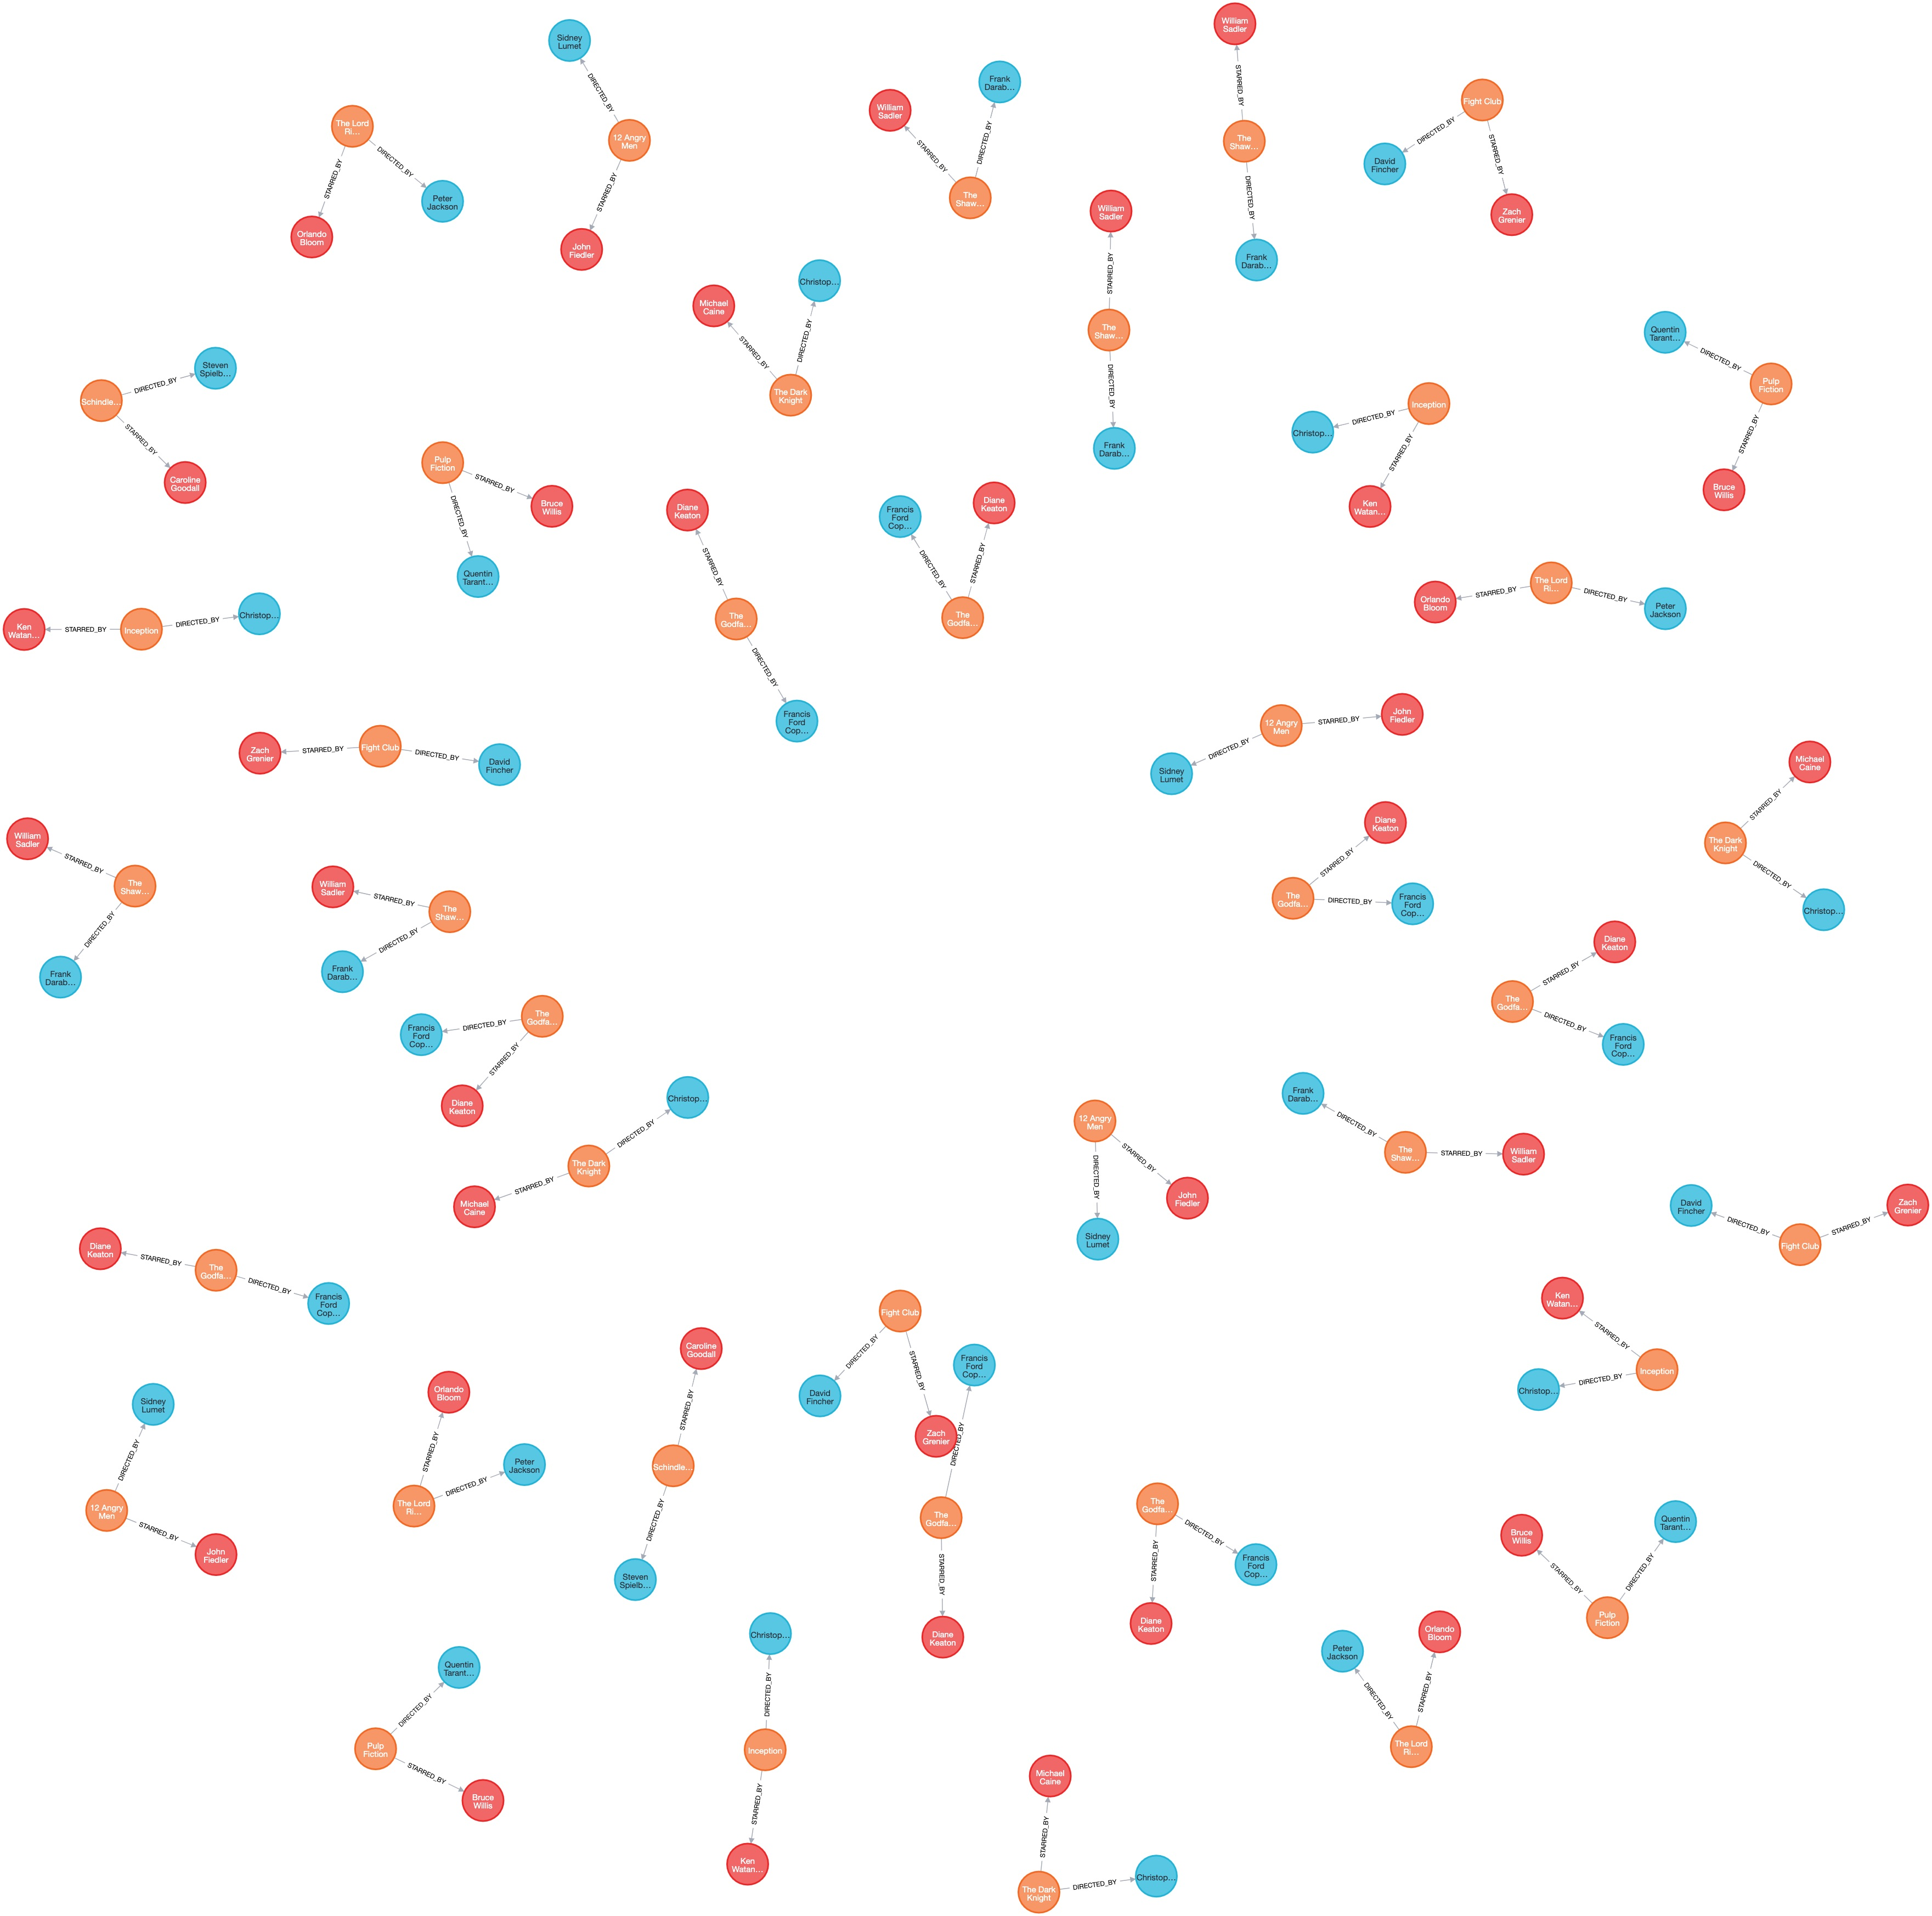

In [47]:
conn.reset_database()

Database resetted successfully!


In [ ]:
llm_transformer = LLMGraphTransformer(llm=llm)

documents = []

for _, row in df.iterrows():
    text = f"Title: {row['Series_Title']}\nDirector: {row['Director']}\nStars: {row['Star1']}, {row['Star2']}, {row['Star3']}, {row['Star4']}\nGenre: {row['Genre']}\nOverview: {row['Overview']}"
    documents.append(Document(page_content=text))


graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

In [ ]:
graph = Neo4jGraph(url=uri, username=user, password=password)
graph.add_graph_documents(graph_documents)

Cypher Query:
```Cypher
MATCH p=(m:Movie)-[r]-(n)
RETURN p;
```

![llm_graph_transformer.jpeg](imgs/llm_graph_transformer.jpeg)

In [ ]:
llm_chat = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=api_key
)

chain = GraphCypherQAChain.from_llm(
    llm, graph=graph, verbose=True, allow_dangerous_requests=True
)

chain.run("What are the top 5 movies?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (m:Movie) RETURN m.title, m.rating ORDER BY m.rating DESC LIMIT 5

Full Context:
[{'m.title': None, 'm.rating': None}, {'m.title': None, 'm.rating': None}, {'m.title': None, 'm.rating': None}, {'m.title': None, 'm.rating': None}, {'m.title': None, 'm.rating': None}]

> Finished chain.


"I don't know the answer.\n"

In [ ]:
conn.reset_database()
conn.close()

Database resetted successfully!
